In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from types import SimpleNamespace

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
'''
params = dict(device=device,
                width=width, lr=1e-3, num_train=60,
                sb=0.05, depth=depth, sw=2.0, early_stop_patience=10, activation_function='relu')
if params['activation_function'] == 'relu':
    activation_function = nn.ReLU
elif params['activation_function'] == 'tanh':
    activation_function = nn.Tanh
else:
    activation_function = nn.Tanh
'''

'''        LOGGING IN ALL THE FUNCTIONS:
    logger can be either print function or logger.info function : this way we can write the outputs to a file as well.
    Example usage to write to a file: (given out_path is a path to a folder)
    """
        import logging
        logger = logging.getLogger(__name__)
        logger.setLevel(logging.DEBUG)

        file = logging.FileHandler(os.path.join(out_path, "outputs.log"))
        file.setLevel(logging.INFO)
        fileformat = logging.Formatter("%(asctime)s:%(levelname)s:%(message)s",datefmt="%H:%M:%S")
        file.setFormatter(fileformat)
        logger.addHandler(file)
    """
    # then you pass the logger to the function (also setting debug=True): multiple_fine_tuning_experiments(num_experiments, cuts, pre_trained_model, dataset_wrapped, params, debug=True, logger=logger)

    To just use the print function, no need to specify the logger:  multiple_fine_tuning_experiments(num_experiments, cuts, pre_trained_model, dataset_wrapped, params, debug=True)
'''
__version__ = '1.1'

import torch
import numpy as np
import random
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import copy


# --------------------------------------------------------------------------------------------------------------------------
# -------------------------------------------- FEED-FORWARD MODEL FUNCTIONS -----------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------------------
# init given linear layer m with given sw and sb
def init_weights(m, sw, sb, default_init=False):
    if type(m) == nn.Linear:
        if default_init:
            m.reset_parameters()
        else:
            nn.init.normal_(m.weight, mean=0.0, std=(np.sqrt(sw / m.out_features)))
            nn.init.normal_(m.bias, mean=0.0, std=np.sqrt(sb))

# init new model
def generate_fc_dnn(input_dim, output_dim, params, activation_function=nn.Tanh, gaussian_init=True):
    depth, width = params['depth'], params['width']
    
    def gen_linear_layer_dim(layer_index):
        return {
            0: (input_dim, width),
            depth - 1: (width, output_dim),
        }.get(layer_index, (width, width))
    
    model = nn.Sequential()
    
    for i in range(depth):
        linear_layer = nn.Linear(*gen_linear_layer_dim(i))
        activation_layer = nn.LogSoftmax(dim=1) if (depth - 1 == i) else activation_function()
        
        # Give descriptive names to layers
        setattr(model, f"linear{i}", linear_layer)
        setattr(model, f"activation{i}", activation_layer)
        
    if gaussian_init:
        model.apply(lambda m: init_weights(m, params['sw'], params['sb']))
    return model

# dataset_loader is fine-tuning dataset
def eval(model, device, dataset_loader, debug=False, logger=print):
    model.eval()
    test_loss, correct = 0., 0.
    with torch.no_grad():
        for data, target in dataset_loader:
            data, target = data.reshape([data.shape[0], -1]).to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(
                output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(
                dim=1,
                keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    num_data = len(dataset_loader.dataset)
    test_loss /= num_data
    acc = correct / num_data
    if debug:
        logger('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.
              format(test_loss, correct, num_data, 100. * acc))

    return acc

def compute_training_acc(model, dataset, params, debug=False, logger=print):
    device = torch.device(params['device'])
    optimizer = optim.SGD(model.parameters(), lr=params['lr'])
    # if debug: print(model, optimizer)

    # run training for few steps and return the accuracy
    train_acc = 0.0
    model.train()
    for batch_idx, (data, target) in enumerate(dataset.train_loader):
        data, target = data.reshape([data.shape[0],-1]).to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        # Evaluate after every 10 steps epoch
        if debug and batch_idx % 10 == 0:
            train_acc = eval(model, device, dataset.train_loader, debug=False)
            logger('Step: {} \tTraining Accuracy: {:.2f}%'.format(batch_idx, train_acc*100))
            # if debug and (epoch+1) % 1 == 0:
            val_acc = eval(model, device, dataset.val_loader, debug=False)
            logger('\t\tValidation Accuracy: {:.2f}%'.format(val_acc*100))

    train_acc = eval(model, device, dataset.train_loader, debug=False)
    test_acc = eval(model, device, dataset.test_loader, debug=False)
    return train_acc, test_acc, model

# like previous function, but run for given number of epochs determined by params['num_train']
def compute_training_acc_epochs(model, dataset, params, debug=False, return_checkpoints=False, save_checkpoints=False, logger=print):
    device = torch.device(params['device'])
    optimizer = optim.SGD(model.parameters(), lr=params['lr'])   
    # if debug: print(model, optimizer)

    if params['early_stop_patience']:
        no_improve_epochs = 0
        max_val_acc = 0.

    train_acc = 0.0
    model.train()
    checkpoints = []

    # Loop over epochs
    for epoch in range(params['num_train']):
        for batch_idx, (data, target) in enumerate(dataset.train_loader):
            data, target = data.reshape([data.shape[0], -1]).to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

            if debug and batch_idx % 20 == 0:
                #logger('Epoch: {} Train step: {} \tLoss: {:.6f}'.format(epoch, batch_idx, loss.item()))
                pass

        # Evaluate after each epoch
        train_acc = eval(model, device, dataset.train_loader, debug=False)
        val_acc = eval(model, device, dataset.val_loader, debug=False)
        if debug: 
            logger('Epoch: {} \tTraining Accuracy: {:.2f}%'.format(epoch, train_acc*100))
            # if debug and (epoch+1) % 1 == 0:  
            logger('Validation Accuracy: {:.2f}%'.format(val_acc*100))

        if params['early_stop_patience']:
            if val_acc > max_val_acc:
                max_val_acc = val_acc
                no_improve_epochs = 0
            else:
                no_improve_epochs += 1
                logger("val_acc: {}, max_val_acc: {}, no_improve_epochs: {}".format(val_acc, max_val_acc, no_improve_epochs))
                if no_improve_epochs >= params['early_stop_patience']:
                    logger("Early stopping invoked.")
                    break
        
        if return_checkpoints or save_checkpoints:
            # Save checkpoint after each epoch
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_acc': train_acc,
                'val_acc': val_acc
            }
            checkpoints.append(checkpoint)
        if save_checkpoints:
            torch.save(checkpoint, 'checkpoint_epoch_{}.pth'.format(epoch))

    # Final evaluation after all epochs are completed
    train_acc = eval(model, device, dataset.train_loader, debug=False)
    test_acc = eval(model, device, dataset.test_loader, debug=False)
    if save_checkpoints or return_checkpoints:
        return train_acc, test_acc, model, checkpoints
    else:
        return train_acc, test_acc, model, []

# cut_point: no. of layers to keep in the model
# reinitialize after cutting point using init_weights function
def cut_model(model, sw = 1, sb = 1, gaussian_init=True, cut_point=1, freeze=True, reinitialize=True):
    #deepcopy to avoid changing the original model
    model = copy.deepcopy(model)
    # Convert sequential model to list of layers
    layers = list(model.named_children())

    # Check if cut_point is out of range
    if cut_point < 0 or cut_point >= len(layers) // 2:
        raise ValueError("cut_point should be in range [0, number of layers - 1]")

    # If freeze is True, set requires_grad to False for layers before cut_point
    if freeze:
        for i in range(cut_point):
            for param in layers[2*i][1].parameters():
                param.requires_grad = False

    # Cut layers
    new_layers = layers[:2*cut_point]

    # Reinitialize layers after cut point
    for i in range(cut_point, len(layers) // 2):
        linear_layer = layers[2*i]
        activation = layers[2*i + 1]

        if reinitialize:
            # Apply initialization
            init_weights(linear_layer, sw, sb, default_init=not gaussian_init)

        # Append to new layers
        new_layers.extend([linear_layer, activation])

    # Return new model
    model = nn.Sequential()
    for name, layer in new_layers:
        setattr(model, name, layer)
    return model

# If num_experiments == 1: after getting the outputs  cut_models = experiments[0] and then this is a simple fine-tuning experiment
# Don't forget to switch the dataset to the fine-tuning:    dataset_wrapped.update_phase('finetune')  before calling this function
def multiple_fine_tuning_experiments(num_experiments, cuts, pre_trained_model, dataset_wrapped, params, freeze=True, reinitialize=False, debug=True, logger=print):
    experiments = []
    for i in range(num_experiments):
        if debug:
            logger('\n\nExperiment number: {}'.format(i))
        cut_models = []
        for cut in cuts:
            temp = {}
            temp['cut_model'] = cut_model(pre_trained_model, cut_point=cut, freeze=freeze, reinitialize=reinitialize)
            logger("\n----> Cut: {}".format(cut))
            finetuned_acc, finetuned_test_acc, finetuned_model, checkpoints_temp = compute_training_acc_epochs(temp['cut_model'], dataset_wrapped, params, debug=debug, save_checkpoints=False, return_checkpoints=True, logger=logger)
            temp['finetuned_acc'] = finetuned_acc
            temp['finetuned_test_acc'] = finetuned_test_acc
            temp['finetuned_model'] = finetuned_model
            temp['checkpoints'] = checkpoints_temp
            cut_models.append(temp)  
        experiments.append(cut_models)
    return experiments
# -----------------------------------------------------------------------------------------------------------------------------------
# ------------------------------------------- CNNS (will need some updating) --------------------------------------------
# -----------------------------------------------------------------------------------------------------------------------------------

class CustomCNN(nn.Module):
    def __init__(self, input_dim, output_dim, depth, num_channels, act_fn, use_pooling=True):
        super(CustomCNN, self).__init__()
        
        in_channels = 1  # Assuming grayscale input images

        for i in range(depth):
            # Add convolutional layer
            setattr(self, f"conv{i}", nn.Conv2d(in_channels, num_channels, kernel_size=3, padding=1))
            
            # Add activation layer
            setattr(self, f"act{i}", act_fn())

            # Add MaxPool2d layer every 2 convolutional layers if use_pooling is set
            if use_pooling and i % 2 == 1:
                setattr(self, f"pool{i}", nn.MaxPool2d(2))
                input_dim = input_dim // 2

            in_channels = num_channels

        flattened_size = in_channels * input_dim * input_dim
        self.fc = nn.Linear(flattened_size, output_dim)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        for layer_name in list(self._modules.keys())[:-2]:  # excluding fc and logsoftmax
            layer = getattr(self, layer_name)
            x = layer(x)
        
        #print(x.size())  # Print the tensor size before flattening
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return self.logsoftmax(x)


def generate_cnn(input_dim, output_dim, depth, num_channels, act_fn=nn.ReLU, use_pooling=True):
    model = CustomCNN(input_dim, output_dim, depth, num_channels, act_fn, use_pooling)
    return model

def compute_training_acc_epochs_cnn(model, dataset, params, debug=False, logger=print):
    device = torch.device(params['device'])
    optimizer = optim.SGD(model.parameters(), lr=params['lr'])
    
    if debug: 
        logger(model, optimizer)

    train_acc = 0.0
    model.train()

    # Loop over epochs
    for epoch in range(params['num_train']):
        for batch_idx, (data, target) in enumerate(dataset.train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

            if debug and batch_idx % 20 == 0:
                pass

        # Evaluate after each epoch
        if debug:
            train_acc = eval_cnn(model, device, dataset.train_loader, debug=False)
            logger('Epoch: {} \tTraining Accuracy: {:.2f}%'.format(epoch, train_acc*100))
            if debug and (epoch+1) % 1 == 0:
                val_acc = eval_cnn(model, device, dataset.val_loader, debug=False)
                logger('Validation Accuracy: {:.2f}%'.format(val_acc*100))
                
    # Final evaluation after all epochs are completed
    train_acc = eval_cnn(model, device, dataset.train_loader, debug=False)
    test_acc = eval_cnn(model, device, dataset.test_loader, debug=False)
    return train_acc, test_acc, model

def eval_cnn(model, device, dataset_loader, debug=False, logger=print):
    model.eval()
    test_loss, correct = 0., 0.
    with torch.no_grad():
        for data, target in dataset_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    num_data = len(dataset_loader.dataset)
    test_loss /= num_data
    acc = correct / num_data
    if debug:
        logger('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, num_data, 100. * acc))

    return acc


def cut_cnn_model(model, cut_point=1, freeze=True, reinitialize=True):
    """
    Cut the CNN model at a specific layer and reinitialize the weights for layers after cut_point if reinitialize is True.

    Parameters:
    - model (nn.Module): Original model.
    - cut_point (int): Layer index at which to cut the model.
    - freeze (bool): If True, layers before cut_point will have their weights frozen.
    - reinitialize (bool): If True, layers after cut_point will have their weights reinitialized.

    Returns:
    - new_model (nn.Sequential): Cut and potentially modified model.
    """
    
    # Deep copy to avoid changing the original model
    model = copy.deepcopy(model)

    # Convert sequential model to list of layers
    layers = list(model.children())

    # Check if cut_point is out of range
    if cut_point < 0 or cut_point >= len(layers):
        raise ValueError("cut_point should be in range [0, number of layers - 1]")

    # If freeze is True, set requires_grad to False for layers before cut_point
    if freeze:
        for i in range(cut_point):
            for param in layers[i].parameters():
                param.requires_grad = False

    # Cut layers
    new_layers = layers[:cut_point]

    # Reinitialize or keep layers after cut point
    for i in range(cut_point, len(layers)):
        layer = layers[i]
        
        # If reinitialize is True, reset weights of the layers having parameters (like Conv2d)
        if reinitialize and hasattr(layer, 'weight'):
            nn.init.kaiming_uniform_(layer.weight, a=0, mode='fan_in', nonlinearity='relu')
            if layer.bias is not None:
                nn.init.constant_(layer.bias, 0)
        
        # Append to new layers
        new_layers.append(layer)

    # Return new model
    return nn.Sequential(*new_layers)


def cut_cnn_model_orthogonal(model, cut_point=1, freeze=True):
    """
    Cut the CustomCNN model at a specific layer and reinitialize the weights for layers after cut_point.

    Parameters:
    - model (CustomCNN): Original model.
    - cut_point (int): Layer index at which to cut the model.
    - freeze (bool): If True, layers before cut_point will have their weights frozen.

    Returns:
    - new_model (CustomCNN): Cut and potentially modified model.
    """
    
    # Deep copy to avoid changing the original model
    model = copy.deepcopy(model)

    # Convert modules to a list for ease of access
    layers = list(model.named_children())
    
    current_layer = 0
    for name, layer in layers:
        # Check the type of layer and decide on actions
        if isinstance(layer, nn.Conv2d):
            if current_layer < cut_point:
                if freeze:
                    for param in layer.parameters():
                        param.requires_grad = False
            else:
                # Reinitialize weights for layers after the cut point
                weights_init(layer)
            current_layer += 1

    return model

# ------------------------------------------------------------- HELPER FUNCTIONS FOR CNN ORTHOGONAL WEIGHT INIT (from the CNN paper) -------------------------
import torch.nn.init as init
def weights_init(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            if m.weight.shape[0] > m.weight.shape[1]:
                _orthogonal_kernel(m.weight.data)
                m.bias.data.zero_()
            else:
                init.orthogonal(m.weight.data)
                m.bias.data.zero_()

        elif isinstance(m, nn.ConvTranspose2d):
            if m.weight.shape[1] > m.weight.shape[0]:
                ConvT_orth_kernel2D(m.weight.data)
               # m.bias.data.zero_()
            else:
                init.orthogonal(m.weight.data)
               # m.bias.data.zero_()

           # m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            #m.bias.data.zero_()
        elif isinstance(m, nn.BatchNorm2d):
            m.weight.data.normal_(1.0, 0.02)
            m.bias.data.zero_()
'''
Algorithm requires The number of input channels cannot exceed the number of output channels.
 However, some questions may be in_channels>out_channels. 
 For example, the final dense layer in GAN. If counters this case, Orthogonal_kernel is replaced by the common orthogonal init'''
'''
for example,
net=nn.Conv2d(3,64,3,2,1)
net.apply(Conv2d_weights_orth_init)
'''

######################################Generating 2D orthogonal initialization kernel####################################
#generating uniform orthogonal matrix
def _orthogonal_matrix(dim):
    a = torch.zeros((dim, dim)).normal_(0, 1)
    q, r = torch.qr(a)
    d = torch.diag(r, 0).sign()
    diag_size = d.size(0)
    d_exp = d.view(1, diag_size).expand(diag_size, diag_size)
    q.mul_(d_exp)
    return q

#generating orthogonal projection matrix,i.e. the P,Q of Algorithm1 in the original
def _symmetric_projection(n):
    """Compute a n x n symmetric projection matrix.
    Args:
      n: Dimension.
    Returns:
      A n x n orthogonal projection matrix, i.e. a matrix P s.t. P=P*P, P=P^T.
    """
    q = _orthogonal_matrix(n)
    # randomly zeroing out some columns
    # mask = math.cast(random_ops.random_normal([n], seed=self.seed) > 0,
    # #                      self.dtype)
    mask = torch.randn(n)

    c = torch.mul(mask,q)
    U,_,_= torch.svd(c)
    U1 = U[:,0].view(len(U[:,0]),1)
    P = torch.mm(U1,U1.t())
    P_orth_pro_mat = torch.eye(n)-P
    return P_orth_pro_mat

#generating block matrix the step2 of the Algorithm1 in the original
def _block_orth(p1, p2):
    """Construct a 2 x 2 kernel. Used to construct orthgonal kernel.
    Args:
      p1: A symmetric projection matrix (Square).
      p2: A symmetric projection matrix (Square).
    Returns:
      A 2 x 2 kernel [[p1p2,         p1(1-p2)],
                      [(1-p1)p2, (1-p1)(1-p2)]].
    Raises:
      ValueError: If the dimensions of p1 and p2 are different.
    """
    if p1.shape != p2.shape:
        raise ValueError("The dimension of the matrices must be the same.")
    kernel2x2 = {}#Block matrices are contained by a dictionary
    eye = torch.eye(p1.shape[0])
    kernel2x2[0, 0] = torch.mm(p1, p2)
    kernel2x2[0, 1] = torch.mm(p1, (eye - p2))
    kernel2x2[1, 0] = torch.mm((eye - p1), p2)
    kernel2x2[1, 1] = torch.mm((eye - p1), (eye - p2))

    return kernel2x2

#compute convolution operator of equation2.17 in the original
def _matrix_conv(m1, m2):
    """Matrix convolution.
    Args:
      m1: A k x k dictionary, each element is a n x n matrix.
      m2: A l x l dictionary, each element is a n x n matrix.
    Returns:
      (k + l - 1) * (k + l - 1) dictionary each element is a n x n matrix.
    Raises:
      ValueError: if the entries of m1 and m2 are of different dimensions.
    """

    n = m1[0, 0].shape[0]
    if n != m2[0, 0].shape[0]:
        raise ValueError("The entries in matrices m1 and m2 "
                         "must have the same dimensions!")
    k = int(np.sqrt(len(m1)))
    l = int(np.sqrt(len(m2)))
    result = {}
    size = k + l - 1
    # Compute matrix convolution between m1 and m2.
    for i in range(size):
        for j in range(size):
            result[i, j] = torch.zeros(n,n)
            for index1 in range(min(k, i + 1)):
                for index2 in range(min(k, j + 1)):
                    if (i - index1) < l and (j - index2) < l:
                        result[i, j] += torch.mm(m1[index1, index2],
                                                        m2[i - index1, j - index2])
    return result

def _dict_to_tensor(x, k1, k2):
    """Convert a dictionary to a tensor.
    Args:
      x: A k1 * k2 dictionary.
      k1: First dimension of x.
      k2: Second dimension of x.
    Returns:
      A k1 * k2 tensor.
    """
    return torch.stack([torch.stack([x[i, j] for j in range(k2)])
                            for i in range(k1)])

#generating a random 2D orthogonal Convolution kernel
def _orthogonal_kernel(tensor):
    """Construct orthogonal kernel for convolution.
    Args:
      ksize: Kernel size.
      cin: Number of input channels.
      cout: Number of output channels.
    Returns:
      An [ksize, ksize, cin, cout] orthogonal kernel.
    Raises:
      ValueError: If cin > cout.
    """
    ksize = tensor.shape[2]
    cin = tensor.shape[1]
    cout = tensor.shape[0]
    if cin > cout:
        raise ValueError("The number of input channels cannot exceed "
                         "the number of output channels.")
    orth = _orthogonal_matrix(cout)[0:cin, :]#这就是算法1中的H
    if ksize == 1:
        return torch.unsqueeze(torch.unsqueeze(orth,0),0)

    p = _block_orth(_symmetric_projection(cout),
                         _symmetric_projection(cout))
    for _ in range(ksize - 2):
        temp = _block_orth(_symmetric_projection(cout),
                                _symmetric_projection(cout))
        p = _matrix_conv(p, temp)
    for i in range(ksize):
        for j in range(ksize):
            p[i, j] = torch.mm(orth, p[i, j])
    tensor.copy_(_dict_to_tensor(p, ksize, ksize).permute(3,2,1,0))
    return tensor

#defining 2DConvT orthogonal initialization kernel
def ConvT_orth_kernel2D(tensor):
    ksize = tensor.shape[2]
    cin = tensor.shape[0]
    cout = tensor.shape[1]
    if cin > cout:
        raise ValueError("The number of input channels cannot exceed "
                         "the number of output channels.")
    orth = _orthogonal_matrix(cout)[0:cin, :]  # 这就是算法1中的H
    if ksize == 1:
        return torch.unsqueeze(torch.unsqueeze(orth, 0), 0)

    p = _block_orth(_symmetric_projection(cout),
                    _symmetric_projection(cout))
    for _ in range(ksize - 2):
        temp = _block_orth(_symmetric_projection(cout),
                           _symmetric_projection(cout))
        p = _matrix_conv(p, temp)
    for i in range(ksize):
        for j in range(ksize):
            p[i, j] = torch.mm(orth, p[i, j])
    tensor.copy_(_dict_to_tensor(p, ksize, ksize).permute(2, 3, 1, 0))
    return tensor
#Call method
def weights_init(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            if m.weight.shape[0] > m.weight.shape[1]:
                _orthogonal_kernel(m.weight.data)
                m.bias.data.zero_()
            else:
                init.orthogonal(m.weight.data)
                m.bias.data.zero_()

        elif isinstance(m, nn.ConvTranspose2d):
            if m.weight.shape[1] > m.weight.shape[0]:
                ConvT_orth_kernel2D(m.weight.data)
               # m.bias.data.zero_()
            else:
                init.orthogonal(m.weight.data)
               # m.bias.data.zero_()

           # m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            #m.bias.data.zero_()
        elif isinstance(m, nn.BatchNorm2d):
            m.weight.data.normal_(1.0, 0.02)
            m.bias.data.zero_()
'''
Algorithm requires The number of input channels cannot exceed the number of output channels.
 However, some questions may be in_channels>out_channels. 
 For example, the final dense layer in GAN. If counters this case, Orthogonal_kernel is replaced by the common orthogonal init'''
'''
for example,
net=nn.Conv2d(3,64,3,2,1)
net.apply(Conv2d_weights_orth_init)
'''

def makeDeltaOrthogonal(in_channels=3, out_channels=64, kernel_size=3, gain=torch.Tensor([1])):
    weights = torch.zeros(out_channels, in_channels, kernel_size, kernel_size)
    out_channels = weights.size(0)
    in_channels = weights.size(1)
    if weights.size(1) > weights.size(0):
        raise ValueError("In_filters cannot be greater than out_filters.")
    q = _orthogonal_matrix(out_channels)
    q = q[:in_channels, :]
    q *= torch.sqrt(gain)
    beta1 = weights.size(2) // 2
    beta2 = weights.size(3) // 2
    weights[:, :, beta1, beta2] = q
    return weights
#Calling method is the same as the above _orthogonal_kernel
######################################################END###############################################################


import torch
import numpy as np
import random
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn.functional as F

# -------------------------------------- Transfer Learning one DAtaset to other --------------------------
# (1, 28, 28) for CNN
# some people transform it to have 0 mean and 1 std?
class MNISTtrainer(object):
    def __init__(self, batch_size, input_dim=28*28,val_split=0.1):
        self.input_dim = input_dim
        self.output_dim = 10
        self.val_split = val_split

        train = datasets.MNIST(
                '../data',
                train=True,
                download=True,
                transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
                ]))
        
        # split some part of train set to validation
        train_set, val_set = torch.utils.data.random_split(train, [1.-self.val_split, self.val_split], generator=torch.Generator().manual_seed(SEED))
        self.train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
        self.val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)
        
        self.test_loader = torch.utils.data.DataLoader(
            datasets.MNIST(
                '../data',
                train=False,
                download=True,
                transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
                ])),
            batch_size=batch_size,
            shuffle=True)
        
# (1, 28, 28) for CNN
class FashionMNISTtrainer(object):
    def __init__(self, batch_size, input_dim=28*28, val_split=0.1):
        self.input_dim = input_dim
        self.output_dim = 10
        self.val_split = val_split


        train = datasets.FashionMNIST(
            '../data',
            train=True,
            download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
            ]))
        
        # split some part of train set to validation
        train_set, val_set = torch.utils.data.random_split(train, [1.-self.val_split, self.val_split], generator=torch.Generator().manual_seed(SEED))
        self.train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
        self.val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)

        self.test_loader = torch.utils.data.DataLoader(
            datasets.FashionMNIST(
                '../data',
                train=False,
                download=True,
                transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
                ])),
            batch_size=batch_size,
            shuffle=True)

# --------------------------------------- TL Using only Different Classes (same dataset) ----------------------
class TransferLearningMNIST(object):
    def __init__(self, batch_size, input_dim=28*28, val_split=0.1):
        self.input_dim = input_dim
        self.output_dim = 10
        self.val_split = val_split

        def filter_dataset(dataset, classes):
            indices = [i for i, t in enumerate(dataset.targets) if t in classes]
            return torch.utils.data.Subset(dataset, indices)
        
        mnist_train_data = datasets.MNIST(
            '../data',
            train=True,
            download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
            ]))

        pretrain_train_data = filter_dataset(mnist_train_data, list(range(5)))
        finetune_train_data = filter_dataset(mnist_train_data, list(range(5, 10)))

        pretrain_len = len(pretrain_train_data)
        finetune_len = len(finetune_train_data)
        pretrain_val_len = int(val_split * pretrain_len)
        finetune_val_len = int(val_split * finetune_len)

        pretrain_train_set, pretrain_val_set = torch.utils.data.random_split(
            pretrain_train_data, [pretrain_len - pretrain_val_len, pretrain_val_len], generator=torch.Generator().manual_seed(SEED))
        finetune_train_set, finetune_val_set = torch.utils.data.random_split(
            finetune_train_data, [finetune_len - finetune_val_len, finetune_val_len], generator=torch.Generator().manual_seed(SEED))

        self.pretrain_train_loader = torch.utils.data.DataLoader(pretrain_train_set, batch_size=batch_size, shuffle=True)
        self.pretrain_val_loader = torch.utils.data.DataLoader(pretrain_val_set, batch_size=batch_size, shuffle=False)
        self.finetune_train_loader = torch.utils.data.DataLoader(finetune_train_set, batch_size=batch_size, shuffle=True)
        self.finetune_val_loader = torch.utils.data.DataLoader(finetune_val_set, batch_size=batch_size, shuffle=False)

        # Separate test loaders
        mnist_test_data = datasets.MNIST(
            '../data',
            train=False,
            download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
            ]))

        pretrain_test_data = filter_dataset(mnist_test_data, list(range(5)))
        finetune_test_data = filter_dataset(mnist_test_data, list(range(5, 10)))

        self.pretrain_test_loader = torch.utils.data.DataLoader(pretrain_test_data, batch_size=batch_size, shuffle=False)
        self.finetune_test_loader = torch.utils.data.DataLoader(finetune_test_data, batch_size=batch_size, shuffle=False)
        self.complete_test_loader = torch.utils.data.DataLoader(mnist_test_data, batch_size=batch_size, shuffle=False)

class TransferLearningMNISTWrapper:
    def __init__(self, transferLearningMNISTObj, phase):
        self.transferLearningMNISTObj = transferLearningMNISTObj
        self.phase = phase
        self.input_dim = self.transferLearningMNISTObj.input_dim
        self.output_dim = self.transferLearningMNISTObj.output_dim
        self.update_phase(phase)
        
    def update_phase(self, phase):
        self.phase = phase
        if phase == 'pretrain':
            self.train_loader = self.transferLearningMNISTObj.pretrain_train_loader
            self.val_loader = self.transferLearningMNISTObj.pretrain_val_loader
            self.test_loader = self.transferLearningMNISTObj.pretrain_test_loader
        elif phase == 'finetune':
            self.train_loader = self.transferLearningMNISTObj.finetune_train_loader
            self.val_loader = self.transferLearningMNISTObj.finetune_val_loader
            self.test_loader = self.transferLearningMNISTObj.finetune_test_loader
        else:
            raise ValueError('Phase must be either "pretrain" or "finetune".')
            
import matplotlib.pyplot as plt
import torch

SEED = 42
import numpy as np
np.random.seed(SEED)

# this function needs some updating if we want to use it
# Plot activation variances of the activation layer and linear activations together, 
# one plot with range and one without (they both have variance of variances)
def plot_variances(variances, results):
    # Create a list of layer names and variances
    layer_names = list(variances.keys())
    variance_values = [variance.mean().item() for variance in variances.values()]
    variance_of_variance_values = [results[layer]['variance_of_variance'] for layer in layer_names]

    # Plot the variances
    plt.figure(figsize=(10, 5))
    plt.plot(layer_names, variance_values, label='Variance')
    plt.plot(layer_names, variance_of_variance_values, label='Variance of Variance', linestyle='--')
    plt.xticks(rotation=90)
    plt.xlabel('Layer Name')
    plt.ylabel('Value')
    plt.title('Activation Variances and Variance of Variances')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Create lists for mean, min, and max variance for each layer
    layer_names = list(variances.keys())
    mean_variances = [variance.mean().item() for variance in variances.values()]
    min_variances = [variance.min().item() for variance in variances.values()]
    max_variances = [variance.max().item() for variance in variances.values()]

    # Plot the variances
    plt.figure(figsize=(10, 5))
    plt.plot(layer_names, mean_variances, label='Mean Variance')
    plt.plot(layer_names, variance_of_variance_values, label='Variance of Variance', linestyle='--')

    # Shade the region between the min and max variance
    plt.fill_between(layer_names , min_variances , max_variances , color='gray', alpha=0.5, label='Variance Range')

    plt.xticks(rotation=90)
    plt.xlabel('Layer Name')
    plt.ylabel('Variance')
    plt.title('Activation Variances, Variance of Variances, and Variance Range')
    plt.tight_layout()
    plt.legend()
    plt.show()
    plt.close()

# HELPER FUNCTION: metrics.compute_layer_variances_dense
def plot_variances_by_layer_type(variances, results, cnn=True, ignore_final_layer=False, std_of_variance=False, save_path=None):
    # Create a list of layer names and variances for fc layers
    if cnn:
        layer_type = 'conv'
    else:
        layer_type = 'lin'
        
    conv_layer_names = [name for name in variances.keys() if layer_type in name]
    conv_variance_values = [np.mean(variance) for name, variance in variances.items() if layer_type in name]

    # Create a list of layer names and variances for activation layers
    activation_layer_names = [name for name in variances.keys() if 'act' in name]
    activation_variance_values = [np.mean(variance) for name, variance in variances.items() if 'act' in name]

    # Extract variance of variance values
    conv_variance_of_variance_values = [results[name]['variance_of_variance'] for name in conv_layer_names]
    activation_variance_of_variance_values = [results[name]['variance_of_variance'] for name in activation_layer_names]

    # Ignore the final layer if specified
    if ignore_final_layer:
        conv_layer_names = conv_layer_names[:-1]
        conv_variance_values = conv_variance_values[:-1]
        conv_variance_of_variance_values = conv_variance_of_variance_values[:-1]

        activation_layer_names = activation_layer_names[:-1]
        activation_variance_values = activation_variance_values[:-1]
        activation_variance_of_variance_values = activation_variance_of_variance_values[:-1]

    # Create lists for mean, min, and max variance for each type of layer
    def extract_variances_from_names(names, variances):
        mean_vals = [np.mean(variances[name]) for name in names]
        return mean_vals

    conv_mean = extract_variances_from_names(conv_layer_names, variances)
    activation_mean = extract_variances_from_names(activation_layer_names, variances)

    def extract_variance_of_variance_from_names(names, results):
        return [results[name]['variance_of_variance'] for name in names]

    conv_vov = extract_variance_of_variance_from_names(conv_layer_names, results)
    activation_vov = extract_variance_of_variance_from_names(activation_layer_names, results)

    # Create a figure with 2 subplots
    if std_of_variance:
        fig, axs = plt.subplots(1, 2, figsize=(15, 10))
    else:
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Plot the variances and variance of variances for conv layers
    axs[0].plot(conv_layer_names, conv_variance_values, label='Variance')
    if std_of_variance:
        axs[0].plot(conv_layer_names, conv_variance_of_variance_values, linestyle='--', label='Std. of Variance')
    axs[0].set_xticklabels(conv_layer_names, rotation=90)
    axs[0].set_xlabel('Layer Name')
    axs[0].set_ylabel('Value')
    axs[0].set_title('{} Layer Variances'.format(layer_type.upper()))
    axs[0].legend()

    # Plot the variances and variance of variances for activation layers
    axs[1].plot(activation_layer_names, activation_variance_values, label='Variance')
    if std_of_variance:
        axs[1].plot(activation_layer_names, activation_variance_of_variance_values, linestyle='--', label='Variance of Variance')
    axs[1].set_xticklabels(activation_layer_names, rotation=90)
    axs[1].set_xlabel('Layer Name')
    axs[1].set_ylabel('Value')
    axs[1].set_title('Activation Layer Variances')
    axs[1].legend()

    # Adjust the layout and display the plot
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()
    plt.close()

# HELPER FUNCTION: metrics.compute_layer_variances_dense
def plot_variances_ranges_by_layer_type(variances, results, cnn=True, ignore_final_layer=False, std_of_variance=True, save_path=None):
    # Create a list of layer names and variances for fc layers
    if cnn:
        layer_type = 'conv'
    else:
        layer_type = 'lin'
        
    conv_layer_names = [name for name in variances.keys() if layer_type in name]
    conv_variance_values = [np.mean(variance) for name, variance in variances.items() if layer_type in name]

    # Create a list of layer names and variances for activation layers
    activation_layer_names = [name for name in variances.keys() if 'act' in name]
    activation_variance_values = [np.mean(variance) for name, variance in variances.items() if 'act' in name]

    # Extract variance of variance values
    conv_variance_of_variance_values = [results[name]['variance_of_variance'] for name in conv_layer_names]
    activation_variance_of_variance_values = [results[name]['variance_of_variance'] for name in activation_layer_names]

    # Ignore the final layer if specified
    if ignore_final_layer:
        conv_layer_names = conv_layer_names[:-1]
        conv_variance_values = conv_variance_values[:-1]
        conv_variance_of_variance_values = conv_variance_of_variance_values[:-1]

        activation_layer_names = activation_layer_names[:-1]
        activation_variance_values = activation_variance_values[:-1]
        activation_variance_of_variance_values = activation_variance_of_variance_values[:-1]

    # Create lists for mean, min, and max variance for each type of layer
    def extract_variances_from_names(names, variances):
        mean_vals = [np.mean(variances[name]) for name in names]
        min_vals = [np.min(variances[name]) for name in names]
        max_vals = [np.max(variances[name]) for name in names]
        return mean_vals, min_vals, max_vals

    conv_mean, conv_min, conv_max = extract_variances_from_names(conv_layer_names, variances)
    activation_mean, activation_min, activation_max = extract_variances_from_names(activation_layer_names, variances)

    def extract_variance_of_variance_from_names(names, results):
        return [results[name]['variance_of_variance'] for name in names]

    conv_vov = extract_variance_of_variance_from_names(conv_layer_names, results)
    activation_vov = extract_variance_of_variance_from_names(activation_layer_names, results)

    # Create a figure with four subplots
    if std_of_variance:
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    else:
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Plot the variances and variance of variances for conv layers
    axs[0, 0].plot(conv_layer_names, conv_variance_values, label='Variance')
    if std_of_variance:
        axs[0, 0].plot(conv_layer_names, conv_variance_of_variance_values, linestyle='--', label='Variance of Variance')
    axs[0, 0].set_xticklabels(conv_layer_names, rotation=90)
    axs[0, 0].set_xlabel('Layer Name')
    axs[0, 0].set_ylabel('Value')
    axs[0, 0].set_title('{} Layer Variances'.format(layer_type.upper()))
    axs[0, 0].legend()

    # Plot the variances and variance of variances for activation layers
    axs[0, 1].plot(activation_layer_names, activation_variance_values, label='Variance')
    if std_of_variance:
        axs[0, 1].plot(activation_layer_names, activation_variance_of_variance_values, linestyle='--', label='Variance of Variance')
    axs[0, 1].set_xticklabels(activation_layer_names, rotation=90)
    axs[0, 1].set_xlabel('Layer Name')
    axs[0, 1].set_ylabel('Value')
    axs[0, 1].set_title('Activation Layer Variances')
    axs[0, 1].legend()

    # Plot the variances for conv layers
    axs[1, 0].plot(conv_layer_names, conv_mean, label='Mean Variance')
    if std_of_variance:
        axs[1, 0].plot(conv_layer_names, conv_vov, linestyle='--', label='Variance of Variance')
    axs[1, 0].fill_between(conv_layer_names, conv_min, conv_max, color='gray', alpha=0.5, label='Variance Range')
    axs[1, 0].set_xticklabels(conv_layer_names, rotation=90)
    axs[1, 0].set_xlabel('Layer Name')
    axs[1, 0].set_ylabel('Value')
    axs[1, 0].set_title('{} Layer Variances'.format(layer_type.upper()))
    axs[1, 0].legend()

    # Plot the variances for activation layers
    axs[1, 1].plot(activation_layer_names, activation_mean, label='Mean Variance')
    if std_of_variance:
        axs[1, 1].plot(activation_layer_names, activation_vov, linestyle='--', label='Variance of Variance')
    axs[1, 1].fill_between(activation_layer_names, activation_min, activation_max, color='gray', alpha=0.5, label='Variance Range')
    axs[1, 1].set_xticklabels(activation_layer_names, rotation=90)
    axs[1, 1].set_xlabel('Layer Name')
    axs[1, 1].set_ylabel('Value')
    axs[1, 1].set_title('Activation Layer Variances')
    axs[1, 1].legend()

    # Adjust the layout and display the plot
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()
    plt.close()

# HELPER FUNCTION: metrics.compute_weight_variances
def plot_weight_variances(weight_variances, variance_of_variance=False, save_path=None, ignore_final_layer=False):
    # Create lists of layer names, variances, and variances of variances
    layer_names = list(weight_variances.keys())
    mean_values = [weight_variances[layer]['mean'] for layer in layer_names]
    variance_values = [weight_variances[layer]['variance'] for layer in layer_names]
    variance_of_variance_values = [weight_variances[layer]['variance_of_variance'] for layer in layer_names]
    
    # Create a figure with 2 subplots
    if variance_of_variance:
        fig, axs = plt.subplots(1, 2, figsize=(15, 10))
    else:
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    if ignore_final_layer:
        layer_names = layer_names[:-1]
        mean_values = mean_values[:-1]
        variance_values = variance_values[:-1]
        variance_of_variance_values = variance_of_variance_values[:-1]

    # Plot the variances and variance of variances for conv layers
    axs[0].plot(layer_names, mean_values, label='Mean')
    axs[0].set_xticklabels(layer_names, rotation=90)
    axs[0].set_xlabel('Layer Name')
    axs[0].set_ylabel('Mean of Weights')
    axs[0].set_title('Mean of Weights of Linear Layers')
    axs[0].legend()

    # Plot the variances and variance of variances for activation layers
    axs[1].plot(layer_names, variance_values, label='Variance')
    if variance_of_variance:
        axs[1].plot(layer_names, variance_of_variance_values, linestyle='--', label='Variance of Variance')
    axs[1].set_xticklabels(layer_names, rotation=90)
    axs[1].set_xlabel('Layer Name')
    axs[1].set_ylabel('Variance of Weights')
    axs[1].set_title('Variance of Weights of Linear Layers')
    axs[1].legend()

    # Adjust the layout and display the plot
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()
    plt.close()

def plot_acc_vs_cut(finetuned_accs, cuts, save_path=None):
    names = [str(cut)+str(1) for cut in cuts]

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    # Plot the variances and variance of variances for conv layers
    axs[0].plot(range(1,len(cuts)+1), finetuned_accs['train'], label='Mean')
    axs[0].set_xticklabels(names, rotation=90)
    axs[0].set_xlabel('Cut')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_title('Train Accuracy on Fine-tuning Set per Cut')
    axs[0].legend()

    # Plot the variances and variance of variances for activation layers
    axs[1].plot(range(1,len(cuts)+1), finetuned_accs['test'], label='Variance')
    axs[1].set_xticklabels(names, rotation=90)
    axs[1].set_xlabel('Cut')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_title('Train Accuracy on Fine-tuning Set per Cut')
    axs[1].legend()

    # Adjust the layout and display the plot
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()
    plt.close()

# HELPER FUNCTION: utils.multiple_fine_tuning_experiments
def box_plot_multiple_exp(experiments, cuts, save_path=None):
    # Initialize lists to store all accuracies for each cut point
    train_accuracies = [[] for _ in cuts]
    test_accuracies = [[] for _ in cuts]

    # Populate the lists with accuracy values
    for cut_models in experiments:
        for cut, model_data in enumerate(cut_models):
            train_accuracies[cut].append(model_data['finetuned_acc'])
            test_accuracies[cut].append(model_data['finetuned_test_acc'])

    # Create a figure with two subplots side by side
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))

    # Plot training accuracies
    axs[0].boxplot(train_accuracies)
    axs[0].set_title('Train Accuracies across Cuts')
    axs[0].set_xlabel('Cut Point')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xticks(range(1,len(cuts)+1))
    axs[0].set_xticklabels(cuts)
    axs[0].grid(True, which='both', linestyle='--', linewidth=0.5)

    # Plot test accuracies
    axs[1].boxplot(test_accuracies)
    axs[1].set_title('Test Accuracies across Cuts')
    axs[1].set_xlabel('Cut Point')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_xticks(range(1,len(cuts)+1))
    axs[1].set_xticklabels(cuts)
    axs[1].grid(True, which='both', linestyle='--', linewidth=0.5)

    # Display the plots
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()
    plt.close()

# not sure if it works with torch Dataloader yet
def plot_decision_boundary(model, X, y, n_classes, loader=None):
    if loader:
        X = loader.dataset.dataset.data.numpy()
        y = loader.dataset.dataset.targets.numpy()
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    with torch.no_grad():
        model.eval()
        Z = model(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])).numpy()
        Z = np.argmax(Z, axis=1)

    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', linewidth=1)
    plt.title("Decision Boundary")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")

    for i in range(n_classes):
        plt.scatter([], [], c='k', alpha=0.8, s=20, label=f"Class {i}")
    plt.legend(loc='upper left')

    plt.show()
    plt.close()

## Testing dataset generation 

ADAM IS THE KEY 

In [3]:
def compute_training_acc_epochs(model, dataset, params, debug=False, save_checkpoints=False, plot_boundary=False):
    device = torch.device(params['device'])
    optimizer = optim.Adam(model.parameters(), lr=params['lr'])   

    best_model_state = None  # To save the best model weights/state
    if params['early_stop_patience']:
        no_improve_epochs = 0
        max_val_acc = 0.

    train_acc = 0.0
    model.train()
    checkpoints = []
    effective_epochs = 0

    # Loop over epochs
    for epoch in range(params['num_train']):
        effective_epochs += 1
        for batch_idx, (data, target) in enumerate(dataset.train_loader):
            data, target = data.reshape([data.shape[0], -1]).to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

        # Evaluate after each epoch
        if debug:
            train_acc = eval(model, device, dataset.train_loader, debug=False)
            val_acc = eval(model, device, dataset.val_loader, debug=False)
            print('Epoch: {} \tTraining Accuracy: {:.2f}%'.format(epoch, train_acc*100))
            print('Validation Accuracy: {:.2f}%'.format(val_acc*100))

        if params['early_stop_patience']:
            if val_acc > max_val_acc:
                max_val_acc = val_acc
                best_model_state = model.state_dict().copy() # This line saves the best model state.
                no_improve_epochs = 0
                best_model_state = model.state_dict()  # Save the best model state
            else:
                no_improve_epochs += 1
                print("val_acc: {}, max_val_acc: {}, no_improve_epochs: {}".format(val_acc, max_val_acc, no_improve_epochs))
                if no_improve_epochs >= params['early_stop_patience']:
                    print("Early stopping invoked.")
                    if best_model_state is not None:
                        model.load_state_dict(best_model_state)  # Load the best model weights
                    break
        
        if save_checkpoints:
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_acc': train_acc,
                'val_acc': val_acc
            }
            torch.save(checkpoint, 'checkpoint_epoch_{}.pth'.format(epoch))
            checkpoints.append(checkpoint)

    # At the end of training, load the best weights if early stopping wasn't invoked 
    # (in case the final epochs did not improve performance)
    if params['early_stop_patience']:
        if not params['early_stop_patience'] or no_improve_epochs < params['early_stop_patience']:
            model.load_state_dict(best_model_state)

    train_acc = eval(model, device, dataset.train_loader, debug=False)
    test_acc = eval(model, device, dataset.test_loader, debug=False)

    if save_checkpoints:
        return train_acc, test_acc, model, checkpoints, effective_epochs
    else:
        return train_acc, test_acc, model, [], effective_epochs


In [4]:
def compute_training_acc_epochs_cnn(model, dataset, params, debug=False, logger=print):
    device = torch.device(params['device'])
    optimizer = optim.SGD(model.parameters(), lr=params['lr'])
    
    best_model_state = None  # To save the best model weights/state
    if params.get('early_stop_patience', None):
        no_improve_epochs = 0
        max_val_acc = 0.

    if debug: 
        logger(model, optimizer)

    train_acc = 0.0
    model.train()

    effective_epochs = 0  # Initialize effective_epochs counter

    # Loop over epochs
    for epoch in range(params['num_train']):
        effective_epochs += 1  # Increment counter for each epoch
        for batch_idx, (data, target) in enumerate(dataset.train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

            if debug and batch_idx % 20 == 0:
                pass

        # Evaluate after each epoch
        if debug:
            train_acc = eval_cnn(model, device, dataset.train_loader, debug=False)
            val_acc = eval_cnn(model, device, dataset.val_loader, debug=False)
            logger('Epoch: {} \tTraining Accuracy: {:.2f}%'.format(epoch, train_acc*100))
            logger('Validation Accuracy: {:.2f}%'.format(val_acc*100))

        if params.get('early_stop_patience', None):
            if val_acc > max_val_acc:
                max_val_acc = val_acc
                best_model_state = model.state_dict().copy() 
                no_improve_epochs = 0
            else:
                no_improve_epochs += 1
                logger("val_acc: {}, max_val_acc: {}, no_improve_epochs: {}".format(val_acc, max_val_acc, no_improve_epochs))
                if no_improve_epochs >= params['early_stop_patience']:
                    logger("Early stopping invoked.")
                    if best_model_state is not None:
                        model.load_state_dict(best_model_state)  # Load the best model weights
                    break

    # At the end of training, load the best weights if early stopping wasn't invoked 
    if params.get('early_stop_patience', None):
        if not params['early_stop_patience'] or no_improve_epochs < params['early_stop_patience']:
            model.load_state_dict(best_model_state)

    train_acc = eval_cnn(model, device, dataset.train_loader, debug=False)
    test_acc = eval_cnn(model, device, dataset.test_loader, debug=False)
    return train_acc, test_acc, model,[], effective_epochs


In [5]:
import torch.utils.data as data

def reduce_dataset(dataloader, percentage, seed=42):
    """
    Reduces the dataset to the given percentage.

    Parameters:
    - dataloader: PyTorch DataLoader object.
    - percentage: Desired percentage of the original dataset.
    - seed: Seed for reproducibility.

    Returns:
    - reduced_dataloader: DataLoader with the reduced dataset.
    """
    # Extract the dataset from the dataloader
    dataset = dataloader.dataset
    
    # Extract all data and labels from the dataset
    X = [dataset[i][0] for i in range(len(dataset))]
    y = [dataset[i][1] for i in range(len(dataset))]

    # Set the seed for reproducibility
    torch.manual_seed(seed)

    # Determine the number of samples to keep
    num_samples = int(len(dataset) * percentage)
    
    # Randomly select indices without replacement
    indices = torch.randperm(len(dataset))[:num_samples]

    # Use a Subset of the original dataset to create a reduced dataset
    reduced_dataset = data.Subset(dataset, indices)

    # Create a DataLoader with the reduced dataset. 
    # You may want to copy other settings from the original DataLoader (like batch_size).
    reduced_dataloader = data.DataLoader(reduced_dataset, batch_size=dataloader.batch_size, shuffle=True)

    return reduced_dataloader

import torch
from torch.utils import data

def reduce_dataset_balanced(dataloader, percentage, seed=42):
    """
    Reduces the dataset to the given percentage ensuring class balance.

    Parameters:
    - dataloader: PyTorch DataLoader object.
    - percentage: Desired percentage of the original dataset.
    - seed: Seed for reproducibility.

    Returns:
    - reduced_dataloader: DataLoader with the reduced dataset.
    """
    # Extract the dataset from the dataloader
    dataset = dataloader.dataset
    
    # Extract all data and labels from the dataset
    X = [dataset[i][0] for i in range(len(dataset))]
    y = [dataset[i][1] for i in range(len(dataset))]

    # Set the seed for reproducibility
    torch.manual_seed(seed)

    # Get unique classes and their counts
    classes, class_counts = torch.unique(torch.tensor(y), return_counts=True)
    
    # Determine the number of samples per class to keep
    num_samples_per_class = int(len(dataset) * percentage / len(classes))
    selected_indices = []

    for class_label in classes:
        class_indices = [i for i, label in enumerate(y) if label == class_label]
        
        # Randomly select indices without replacement for each class
        class_selected_indices = torch.randperm(len(class_indices))[:num_samples_per_class].tolist()
        selected_indices.extend([class_indices[i] for i in class_selected_indices])

    # Use a Subset of the original dataset to create a reduced dataset
    reduced_dataset = data.Subset(dataset, selected_indices)

    # Create a DataLoader with the reduced dataset. 
    # You may want to copy other settings from the original DataLoader (like batch_size).
    reduced_dataloader = data.DataLoader(reduced_dataset, batch_size=dataloader.batch_size, shuffle=True)

    return reduced_dataloader



## Pretraining

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [7]:
batch_size = 128
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'

dataset = TransferLearningMNIST(batch_size)
dataset_wrapped = TransferLearningMNISTWrapper(dataset, 'pretrain')

100%|██████████| 9912422/9912422 [00:00<00:00, 438026373.26it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 133262589.47it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 231138377.61it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7849414.41it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



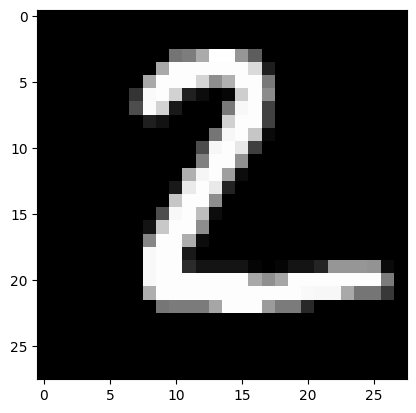

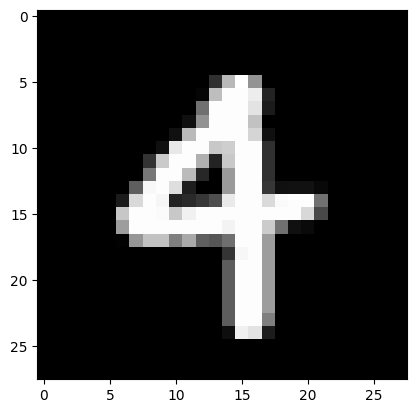

-------------


In [8]:
a = dataset_wrapped.test_loader
b = dataset_wrapped.train_loader

#check if the content of the two loaders are the same, and print the respective mnist images, use zip 
for i, (data_a, data_b) in enumerate(zip(a, b)):
        plt.imshow(data_a[0][0].reshape([28,28]), cmap='gray')
        plt.show()
        plt.imshow(data_b[0][0].reshape([28,28]), cmap='gray')
        plt.show()
        print('-------------')
        break

In [9]:
device = 'cuda'

depth = 3

params = dict(device=device,
                width=2, lr=0.01, num_train=10,
                sb=0.05, depth= depth, sw=1.7346938775510203, early_stop_patience = 4, activation_function='ReLU')

# Create DNN model
model = generate_cnn(28, 10,
                params['depth'], params['width'], act_fn=nn.ReLU, use_pooling=False).to(device)

# Train and evaluate
train_acc, test_acc, model, _, effective_epochs = compute_training_acc_epochs_cnn(model, dataset_wrapped, params, debug=True)

print(f"Final Training Accuracy: {train_acc:.4f}")
print(f"Final Test Accuracy: {test_acc:.4f}")


CustomCNN(
  (conv0): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (fc): Linear(in_features=1568, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
) SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Epoch: 0 	Training Accuracy: 19.03%
Validation Accuracy: 19.65%
Epoch: 1 	Training Accuracy: 19.53%
Validation Accuracy: 17.78%
val_acc: 0.17783589408303366, max_val_acc: 0.19646943445570447, no_improve_epochs: 1
Epoch: 2 	Training Accuracy: 19.53%
Validation Accuracy: 17.78%
val_acc: 0.17783589408303366, max_val_acc: 0.19646943445570447, no_improve_epochs: 2
Epoch: 3 	Training Accuracy: 32.43%
Validation Accuracy: 32.40%
Epoch: 4 	Trai

In [10]:
print(model)

CustomCNN(
  (conv0): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (fc): Linear(in_features=1568, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)


In [11]:
eval_cnn(model, device, dataset_wrapped.test_loader, debug=True)


Train set: Average loss: 0.1311, Accuracy: 4926.0/5139 (96%)



0.9585522475189726

In [12]:
conv_indices = [0, 2, 4]
#print(conv_indices[:0])
for idx in conv_indices[:3]:
    print(idx)

0
2
4


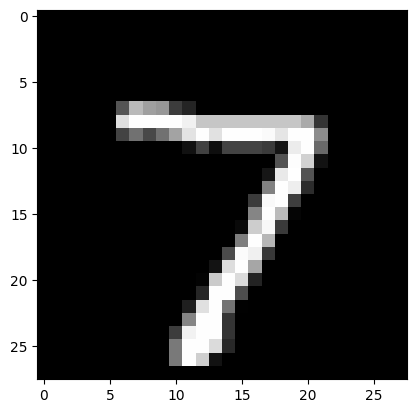

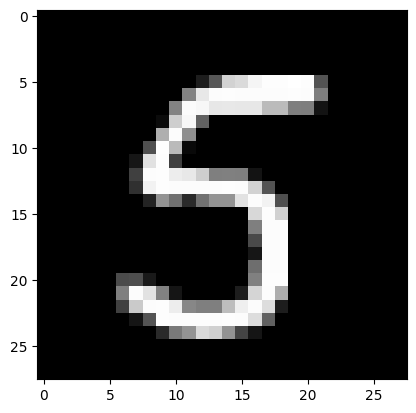

-------------


In [13]:
dataset_wrapped.update_phase('finetune')

a = dataset_wrapped.test_loader
b = dataset_wrapped.train_loader

#check if the content of the two loaders are the same, and print the respective mnist images, use zip 
for i, (data_a, data_b) in enumerate(zip(a, b)):
        plt.imshow(data_a[0][0].reshape([28,28]), cmap='gray')
        plt.show()
        plt.imshow(data_b[0][0].reshape([28,28]), cmap='gray')
        plt.show()
        print('-------------')
        break

In [14]:
def cut_custom_cnn_model(model, cut_point, freeze=True, reinitialize=False):
    """
    Cut the CustomCNN model at a specific layer and reinitialize the weights for layers after cut_point.
    
    Parameters:
    - model (CustomCNN): Original CustomCNN model.
    - cut_point (int): Layer index (in terms of conv layers) at which to modify the model.
    - freeze (bool): If True, layers before cut_point will have their weights frozen.
    - reinitialize (bool): If True, layers after cut_point will have their weights reinitialized.

    Returns:
    - new_model (CustomCNN): Modified model.
    """
    
    new_model = copy.deepcopy(model)

    # Get names of layers in the model
    layer_names = list(new_model._modules.keys())

    # Find indices of Conv layers
    conv_indices = [i for i, name in enumerate(layer_names) if 'conv' in name]
    #print(conv_indices)

    # If freeze is True, set requires_grad to False for layers before cut_point
    if freeze:
        for idx in conv_indices[:cut_point]:
            for param in getattr(new_model, layer_names[idx]).parameters():
                param.requires_grad = False

    # Reinitialize layers after cut_point
    if reinitialize:
        for idx in conv_indices[cut_point:]:
            layer = getattr(new_model, layer_names[idx])
            nn.init.kaiming_uniform_(layer.weight, a=0, mode='fan_in', nonlinearity='relu')
            if layer.bias is not None:
                nn.init.constant_(layer.bias, 0)

    return new_model


# model_new = cut_custom_cnn_model(model, cut_point=1, freeze=True, reinitialize=False)

# # Train and evaluate
# train_acc, test_acc, model_new, _, effective_epochs = compute_training_acc_epochs_cnn(model_new, dataset_wrapped, params, debug=True)

# print(f"Final Training Accuracy: {train_acc:.4f}")
# print(f"Final Test Accuracy: {test_acc:.4f}")

----

In [15]:
# Number of iterations for RandomSearch
max_iterations = 40  # or whatever upper limit you want

# Define the hyperparameter space
percentages_space = [0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
cut_points_space = [1, 2, 3]  # Define suitable cut points

# Calculate the total number of unique combinations
total_combinations = len(percentages_space) * len(cut_points_space)

# Store results
results = []

# Store unique combinations that have been tested
tested_combinations = set()

for _ in range(max_iterations):
    # Sample hyperparameters
    sampled_percentage = random.choice(percentages_space)
    sampled_cut_point = random.choice(cut_points_space)

    # Check if this combination was tested before
    if (sampled_percentage, sampled_cut_point) in tested_combinations:
        continue

    # Add the combination to the tested set
    tested_combinations.add((sampled_percentage, sampled_cut_point))

    # Print or log the sampled values for transparency
    print(f"Sampled Percentage: {sampled_percentage}, Sampled Cut Point: {sampled_cut_point}")

    # Reduce the dataset
    train_loader_reduced = reduce_dataset_balanced(dataset_wrapped.train_loader, sampled_percentage, seed=random.randint(0, 100))

    # Copy and then cut the model
    model_new = copy.deepcopy(model)
    model_new = cut_custom_cnn_model(model_new, cut_point=sampled_cut_point, freeze=True, reinitialize=False)

    # Train and evaluate
    train_acc, test_acc, _, _, _ = compute_training_acc_epochs_cnn(model_new, dataset_wrapped, params, debug=True)

    # Store the results
    results.append((sampled_percentage, sampled_cut_point, train_acc, test_acc))

    # Check if all combinations have been tested
    if len(tested_combinations) >= total_combinations:
        print("All possible combinations have been tested.")
        break

# Process and visualize the results as needed


Sampled Percentage: 0.7, Sampled Cut Point: 1
CustomCNN(
  (conv0): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (fc): Linear(in_features=1568, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
) SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Epoch: 0 	Training Accuracy: 84.58%
Validation Accuracy: 83.98%
Epoch: 1 	Training Accuracy: 92.28%
Validation Accuracy: 91.73%
Epoch: 2 	Training Accuracy: 93.09%
Validation Accuracy: 92.79%
Epoch: 3 	Training Accuracy: 94.25%
Validation Accuracy: 93.78%
Epoch: 4 	Training Accuracy: 94.42%
Validation Accuracy: 93.64%
val_acc: 0.9363945578231293, max_val_acc: 0.9377551020408164, no_improve_e

In [16]:
!pip install plotly

In [17]:
import plotly.express as px
import pandas as pd

# Convert results to a DataFrame
df = pd.DataFrame(results, columns=['Percentage', 'Cut Point', 'Train Accuracy', 'Test Accuracy'])

# Create a 3D scatter plot
fig = px.scatter_3d(df, 
                    x='Percentage', 
                    y='Cut Point', 
                    z='Test Accuracy',  # or 'Train Accuracy' if you want to visualize training accuracy
                    color='Train Accuracy',  # color scale based on test accuracy
                    size_max=18,
                    opacity=0.7)

# Set axis labels
fig.update_layout(scene=dict(xaxis_title='Percentage',
                             yaxis_title='Cut Point',
                             zaxis_title='Test Accuracy'))

fig.show()


In [18]:
df
# color coded matrix with accuracies

,Percentage,Cut Point,Train Accuracy,Test Accuracy
0,0.70,1,0.952502,0.951450
1,0.80,2,0.915281,0.914832
2,0.10,1,0.946304,0.944250
3,0.03,3,0.910029,0.911129
4,0.50,1,0.941505,0.938079
5,0.30,1,0.952502,0.951450
6,0.03,1,0.948987,0.949393
7,0.50,3,0.891248,0.900432
8,0.80,3,0.932512,0.929644
9,0.50,2,0.947929,0.948365


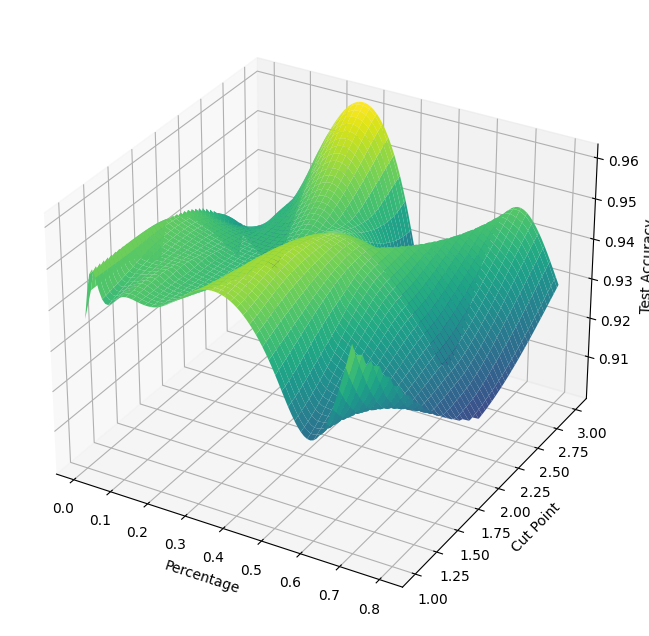

In [19]:
import plotly.graph_objects as go
import numpy as np
from scipy.interpolate import griddata

# Convert results to a DataFrame (assuming results is a list of dictionaries)
df = pd.DataFrame(results)
df.columns = ['Percentage', 'Cut Point', 'Train Accuracy', 'Test Accuracy']

# Create grid values
xi = np.linspace(df['Percentage'].min(), df['Percentage'].max(), 100)
yi = np.linspace(df['Cut Point'].min(), df['Cut Point'].max(), 100)
xi, yi = np.meshgrid(xi, yi)

# Interpolate
zi = griddata((df['Percentage'], df['Cut Point']), df['Test Accuracy'], (xi, yi), method='cubic')

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xi, yi, zi, cmap='viridis')
ax.set_xlabel('Percentage')
ax.set_ylabel('Cut Point')
ax.set_zlabel('Test Accuracy')
plt.show()

------

In [ ]:
import random
import copy

# Number of iterations for RandomSearch
max_iterations = 40  # or whatever upper limit you want

# Define the hyperparameter space
percentages_space = [0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
cut_points_space = [0, 1, 2, 3]  # Define suitable cut points
 
# Number of trials for each combination to reduce noise
num_trials = 3  # Make this number changeable

# Calculate the total number of unique combinations
total_combinations = len(percentages_space) * len(cut_points_space) * num_trials

# Store results
results = []

# Store unique combinations that have been tested
tested_combinations = set()

for _ in range(max_iterations):
    # Sample hyperparameters
    sampled_percentage = random.choice(percentages_space)
    sampled_cut_point = random.choice(cut_points_space)
    for trial in range(num_trials):

        # Create a unique identifier for each trial of a combination
        combination_id = (sampled_percentage, sampled_cut_point, trial)

        # Check if this combination was tested before
        if combination_id in tested_combinations:
            continue

        # Add the combination to the tested set
        tested_combinations.add(combination_id)

        # Print or log the sampled values for transparency
        print(f"Trial: {trial + 1}, Sampled Percentage: {sampled_percentage}, Sampled Cut Point: {sampled_cut_point}")

        # Reduce the dataset
        train_loader_reduced = reduce_dataset_balanced(dataset_wrapped.train_loader, sampled_percentage, seed=random.randint(0, 100))

        # Copy and then cut the model
        model_new = copy.deepcopy(model)
        model_new = cut_custom_cnn_model(model_new, cut_point=sampled_cut_point, freeze=True, reinitialize=False)

        # Train and evaluate
        train_acc, test_acc, _, _, _ = compute_training_acc_epochs_cnn(model_new, dataset_wrapped, params, debug=True)

        # Store the results along with the trial number
        results.append((trial + 1, sampled_percentage, sampled_cut_point, train_acc, test_acc))

    # Check if all combinations have been tested
    if len(tested_combinations) >= total_combinations:
        print("All possible combinations have been tested.")
        break


Trial: 1, Sampled Percentage: 0.03, Sampled Cut Point: 0
CustomCNN(
  (conv0): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (fc): Linear(in_features=1568, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
) SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Epoch: 0 	Training Accuracy: 87.82%
Validation Accuracy: 87.21%
Epoch: 1 	Training Accuracy: 92.54%
Validation Accuracy: 92.41%
Epoch: 2 	Training Accuracy: 89.73%
Validation Accuracy: 89.83%
val_acc: 0.8982993197278911, max_val_acc: 0.9241496598639456, no_improve_epochs: 1
Epoch: 3 	Training Accuracy: 93.46%
Validation Accuracy: 93.10%
Epoch: 4 	Training Accuracy: 94.79%
Validati

In [ ]:
# Convert results to a DataFrame
df = pd.DataFrame(results, columns=['Trial','Percentage', 'Cut Point', 'Train Accuracy', 'Test Accuracy'])
df

------

conv0.weight: 5.0719
conv1.weight: 9.0274
conv2.weight: 8.2683
fc.weight: 9.6556


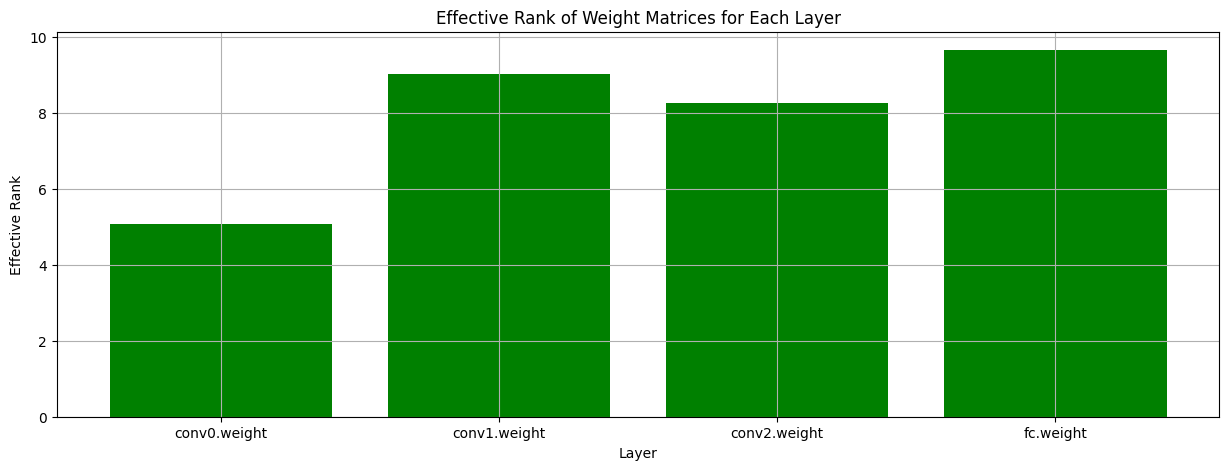

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import torch

'''def effective_rank(singular_values):
    sigma_max = np.max(singular_values)
    sigma_min = singular_values[-1] if singular_values[-1] > 0 else np.min(singular_values[singular_values > 0])
    # print(sigma_max, sigma_min)
    print(np.sqrt(sigma_max / sigma_min))
    print('----')
    return np.sqrt(sigma_max / sigma_min)'''

def effective_rank(singular_values):
    normalized_singular_values = singular_values / np.sum(singular_values)
    entropy = -np.sum(normalized_singular_values * np.log(normalized_singular_values))
    eff_rank = np.exp(entropy)
    return eff_rank

def plot_layer_effective_ranks(model, print_ranks=True):
    effective_ranks = []
    layer_names = []
    
    for name, param in model.named_parameters():
        if 'weight' in name:  # We are only interested in weight matrices
            weight_matrix = param.detach().cpu().numpy()
            singular_values = np.linalg.svd(weight_matrix, compute_uv=False)
            eff_rank = effective_rank(singular_values)
            effective_ranks.append(eff_rank)
            layer_names.append(name)

    if print_ranks:
        for layer_name, eff_rank in zip(layer_names, effective_ranks):
            print(f'{layer_name}: {eff_rank:.4f}')
    
    # Plotting
    plt.figure(figsize=(15, 5))
    plt.bar(layer_names, effective_ranks, color='green')
    plt.xlabel('Layer')
    plt.ylabel('Effective Rank')
    plt.title('Effective Rank of Weight Matrices for Each Layer')
    plt.grid(True)
    
    y_max = np.max(effective_ranks) + 1  # Get maximum rank and add 1 for better visualization
    y_min = np.min(effective_ranks) - 1  # Get minimum rank and subtract 1 for better visualization
    plt.yticks(np.arange(0, int(y_max)+2, step=2))  # Set yticks

    plt.show()

# Example usage
plot_layer_effective_ranks(model)  # Note: You'll need to define or load 'model' before calling this function


----

# Finetuning experiments

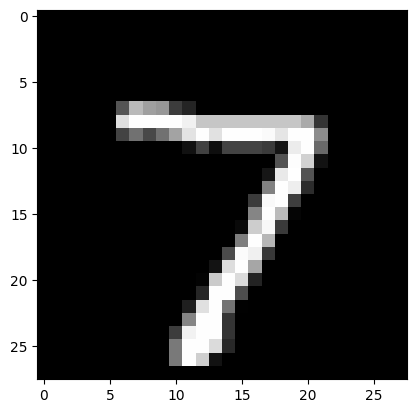

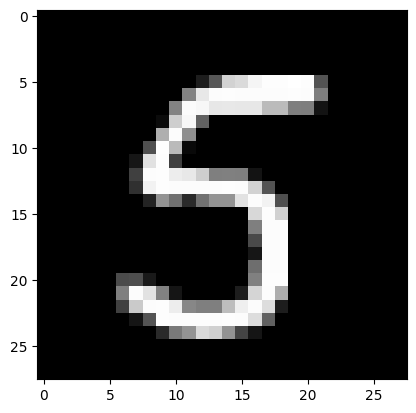

-------------


In [15]:
dataset_wrapped.update_phase('finetune')

a = dataset_wrapped.test_loader
b = dataset_wrapped.train_loader

#check if the content of the two loaders are the same, and print the respective mnist images, use zip 
for i, (data_a, data_b) in enumerate(zip(a, b)):
        plt.imshow(data_a[0][0].reshape([28,28]), cmap='gray')
        plt.show()
        plt.imshow(data_b[0][0].reshape([28,28]), cmap='gray')
        plt.show()
        print('-------------')
        break


## Baseline model: end2end with the same architecture as the preatining model

In [11]:
# 2. Create a new model and copy weights from the original model, then adjust the final layer
model_finetuning_baseline = generate_cnn(28, 10,
                params['depth'], params['width'], act_fn=nn.ReLU, use_pooling=False).to(device)

dataset_wrapped.update_phase('finetune')
# Train and evaluate the new model on the new data
train_acc_new, test_acc_new, model_finetuning_baseline, _,_ = compute_training_acc_epochs_cnn(model_finetuning_baseline, dataset_wrapped, params, debug=True)

print(f"Final Training Accuracy (New Data): {train_acc_new:.4f}")
print(f"Final Test Accuracy (New Data): {test_acc_new:.4f}")

CustomCNN(

  (conv0): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

  (act0): ReLU()

  (conv1): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

  (act1): ReLU()

  (conv2): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

  (act2): ReLU()

  (fc): Linear(in_features=1568, out_features=10, bias=True)

  (logsoftmax): LogSoftmax(dim=1)

) SGD (

Parameter Group 0

    dampening: 0

    differentiable: False

    foreach: None

    lr: 0.01

    maximize: False

    momentum: 0

    nesterov: False

    weight_decay: 0

)

Epoch: 0 	Training Accuracy: 34.48%

Validation Accuracy: 36.33%

Epoch: 1 	Training Accuracy: 91.41%

Validation Accuracy: 90.41%

Epoch: 2 	Training Accuracy: 93.43%

Validation Accuracy: 92.96%

Epoch: 3 	Training Accuracy: 94.22%

Validation Accuracy: 93.91%

Epoch: 4 	Training Accuracy: 95.37%

Validation Accuracy: 95.10%

Epoch: 5 	Training Accuracy: 95.42%

Validation Accuracy: 95.27%

Epoch: 6 	Training Accur

conv0.weight: 4.6467

conv1.weight: 9.9939

conv2.weight: 7.7532

fc.weight: 9.5620


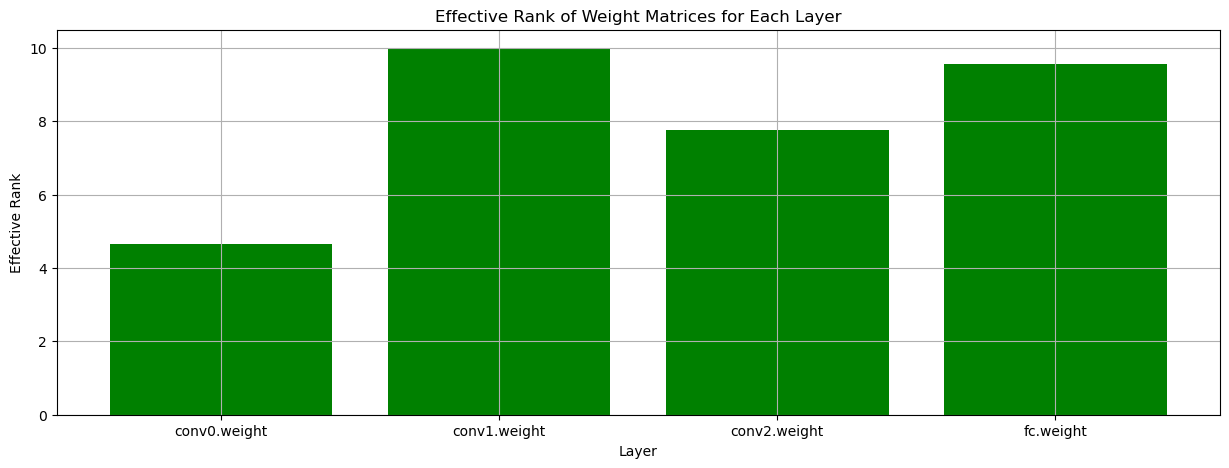

In [14]:
#eval(model, device, dataset_wrapped.test_loader, debug=True, classification_report_flag = True)
plot_layer_effective_ranks(model_finetuning_baseline)
# results, variances = compute_layer_variances_dense(model_finetuning_baseline, test_loader_transfer, device = 'cpu',cnn=False)
# plot_variances_by_layer_type(variances, results, cnn = False, ignore_final_layer=True, std_of_variance = True )

now with balanced classes

Percentage: 0.01

Repeat: 0, with seed 33 =========================

CustomCNN(

  (conv0): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

  (act0): ReLU()

  (conv1): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

  (act1): ReLU()

  (conv2): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

  (act2): ReLU()

  (fc): Linear(in_features=1568, out_features=10, bias=True)

  (logsoftmax): LogSoftmax(dim=1)

) SGD (

Parameter Group 0

    dampening: 0

    differentiable: False

    foreach: None

    lr: 0.01

    maximize: False

    momentum: 0

    nesterov: False

    weight_decay: 0

)

Epoch: 0 	Training Accuracy: 20.00%

Validation Accuracy: 18.71%

Epoch: 1 	Training Accuracy: 20.00%

Validation Accuracy: 18.71%

val_acc: 0.1870748299319728, max_val_acc: 0.1870748299319728, no_improve_epochs: 1

Epoch: 2 	Training Accuracy: 20.00%

Validation Accuracy: 18.71%

val_acc: 0.1870748299319728, max_val_acc: 0.1870748299319728, no_impr

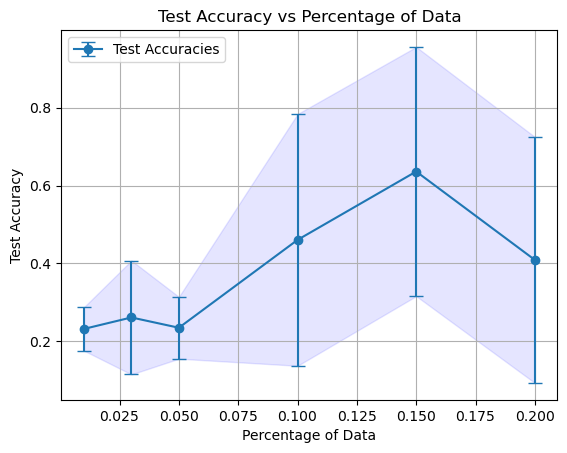

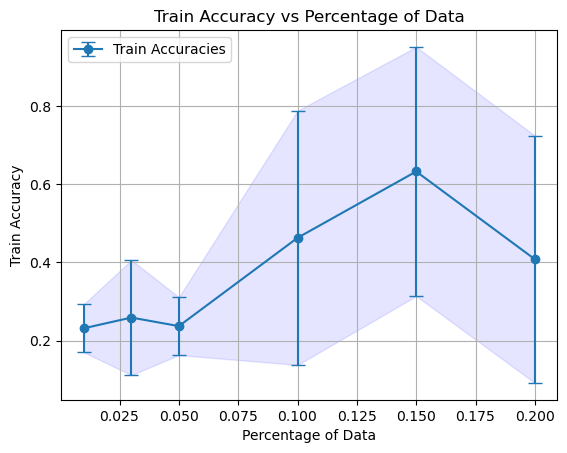

In [69]:
import numpy as np
import matplotlib.pyplot as plt

dataset_wrapped.update_phase('finetune')

#percentages = np.linspace(0.1, 1.0, 10)  # from 10% to 100%
percentages = [0.01, 0.03, 0.05, 0.1, 0.15, 0.2]
seed_set = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
repeats = 3

params['lr'] = 0.01    
params['num_train'] = 10
params['early_stop_patience'] = 4

# Store results for each percentage
results_test = {}
results_train = {}
best_models = {}
data_loaders = {}
epochs_taken = {}  # Dictionary to store the number of epochs for each (perc, seed) tuple

for perc in percentages:
    print(f"Percentage: {perc}")
    test_accuracies = []
    train_accuracies = []
    epochs_for_this_percentage = []  # Store epochs for this percentage

    for _, temp_seed in enumerate(seed_set):
        #temp_seed as a random seed 
        temp_seed  = random.randint(0, 100)
        print(f"Repeat: {_}, with seed {temp_seed} =========================")
        model_new =  generate_cnn(28, 10,
                params['depth'], params['width'], act_fn=nn.ReLU, use_pooling=False).to(device)
        
        # Reduce datasets
        train_loader_transfer_reduced = reduce_dataset_balanced(dataset_wrapped.train_loader, perc, seed=temp_seed)
        if _ == 0:
            data_loaders[perc] = train_loader_transfer_reduced
        test_loader_transfer_reduced = dataset_wrapped.test_loader
        val_loader_transfer_reduced = dataset_wrapped.val_loader
        
        dataset_namespace_new = SimpleNamespace(train_loader=train_loader_transfer_reduced, test_loader=test_loader_transfer_reduced, val_loader=val_loader_transfer_reduced)
        
        train_acc_new, test_acc_new, _, _, num_epochs = compute_training_acc_epochs_cnn(model_new, dataset_namespace_new, params, debug=True)
        
        test_accuracies.append(test_acc_new)
        train_accuracies.append(train_acc_new)
        epochs_for_this_percentage.append(num_epochs)

        print('eval on reduced train set')
        eval_cnn(model_new, device, train_loader_transfer_reduced, debug=True)
        print('eval on full test set')
        eval_cnn(model_new, device, test_loader_transfer_reduced, debug=True)

        # Uncomment this block if you need the best model per percentage logic
        # if train_acc_new > best_accuracy:
        #     best_accuracy = train_acc_new
        #     best_models[perc] = model_new.state_dict()  # Save only the model's parameters (state_dict)
        
    results_test[perc] = test_accuracies
    results_train[perc] = train_accuracies
    epochs_taken[perc] = epochs_for_this_percentage

# Now, you can print or store the number of epochs for each (percentage, seed) tuple:
for perc in percentages:
    for seed, epoch_num in zip(seed_set, epochs_taken[perc]):
        print(f"Percentage: {perc}, Seed: {seed}, Epochs taken: {epoch_num}")


# Save the best models
# for perc in best_models:
#     torch.save(best_models[perc], f"best_model_{int(perc*100)}_percent.pth")

# Plot the results
means = [np.mean(results_test[perc]) for perc in percentages]
stds = [np.std(results_test[perc]) for perc in percentages]
plt.errorbar(percentages, means, yerr=stds, fmt='-o', capsize=5, label="Test Accuracies")
plt.fill_between(percentages, np.subtract(means, stds), np.add(means, stds), color='b', alpha=0.1)

plt.xlabel("Percentage of Data")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy vs Percentage of Data")
plt.legend()
plt.grid(True)
plt.show()

#plot the training accuracies
means = [np.mean(results_train[perc]) for perc in percentages]
stds = [np.std(results_train[perc]) for perc in percentages]
plt.errorbar(percentages, means, yerr=stds, fmt='-o', capsize=5, label="Train Accuracies")
plt.fill_between(percentages, np.subtract(means, stds), np.add(means, stds), color='b', alpha=0.1)

plt.xlabel("Percentage of Data")
plt.ylabel("Train Accuracy")
plt.title("Train Accuracy vs Percentage of Data")
plt.legend()
plt.grid(True)
plt.show()


## Only heads and data for new classes

now with balanced classes

In [10]:
#length of train_loader_transfer_reduced
print(len(train_loader_transfer_reduced.dataset))
len(dataset_wrapped.train_loader.dataset)

NameError: name 'train_loader_transfer_reduced' is not defined

In [23]:
import numpy as np
import matplotlib.pyplot as plt

dataset_wrapped.update_phase('finetune')

percentages = [0.01, 0.03, 0.05, 0.1, 0.15, 0.2]
seed_set = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
repeats = 3

params['lr'] = 0.01  
params['num_train'] = 10
params['early_stop_patience'] = 4

# Store results for each percentage
results_test_finetune = {}
results_train_finetune = {}
best_models = {}
data_loaders = {}
epochs_taken_finetune = {}  # Dictionary to store the number of epochs for each (perc, seed) tuple

for perc in percentages:
    print(f"Percentage: {perc}")
    test_accuracies = []
    train_accuracies = []
    epochs_for_this_percentage = []  # Store epochs for this percentage

    for _, temp_seed in enumerate(seed_set):
        #temp_seed as a random seed 
        temp_seed  = random.randint(0, 100)
        print(f"Repeat: {_}, with seed {temp_seed} =========================")

        ''' model_new = generate_fc_dnn(dataset.input_dim, 10, params, gaussian_init=False, activation_function = nn.ReLU)

        # Copy weights
        for name, param in model.named_parameters():
            if "linear" + str(depth) not in name:
                model_new._parameters[name] = param'''
    
        model_new = copy.deepcopy(model)

        #cut model 
        #model_new = cut_custom_cnn_model(model_new, cut_point=1, freeze=True, reinitialize=False)

        #freeze them 
        # for name, param in model.named_parameters():
        #     if "linear" + str(depth-1) not in name:
        #         param.requires_grad = False
        
        # Reduce datasets
        train_loader_transfer_reduced = reduce_dataset_balanced(dataset_wrapped.train_loader, perc, seed=temp_seed)
        if _ == 0:
            data_loaders[perc] = train_loader_transfer_reduced
        test_loader_transfer_reduced = dataset_wrapped.test_loader
        val_loader_transfer_reduced = dataset_wrapped.val_loader
        
        dataset_namespace_new = SimpleNamespace(train_loader=train_loader_transfer_reduced, test_loader=test_loader_transfer_reduced, val_loader=val_loader_transfer_reduced)
        
        train_acc_new, test_acc_new, _, _, num_epochs = compute_training_acc_epochs_cnn(model_new, dataset_namespace_new, params, debug=True)
        
        test_accuracies.append(test_acc_new)
        train_accuracies.append(train_acc_new)
        epochs_for_this_percentage.append(num_epochs)

        print('eval on reduced train set')
        eval_cnn(model_new, device, train_loader_transfer_reduced, debug=True)
        print('eval on full test set')
        eval_cnn(model_new, device, test_loader_transfer_reduced, debug=True)

        # Uncomment this block if you need the best model per percentage logic
        # if train_acc_new > best_accuracy:
        #     best_accuracy = train_acc_new
        #     best_models[perc] = model_new.state_dict()  # Save only the model's parameters (state_dict)
        
    results_test_finetune[perc] = test_accuracies
    results_train_finetune[perc] = train_accuracies
    epochs_taken_finetune[perc] = epochs_for_this_percentage

# Now, you can print or store the number of epochs for each (percentage, seed) tuple:
for perc in percentages:
    for seed, epoch_num in zip(seed_set, epochs_taken_finetune[perc]):
        print(f"Percentage: {perc}, Seed: {seed}, Epochs taken: {epoch_num}")


# Save the best models
# for perc in best_models:
#     torch.save(best_models[perc], f"best_model_{int(perc*100)}_percent.pth")

# Plot the results
means = [np.mean(results_test_finetune[perc]) for perc in percentages]
stds = [np.std(results_test_finetune[perc]) for perc in percentages]
plt.errorbar(percentages, means, yerr=stds, fmt='-o', capsize=5, label="Test Accuracies")
plt.fill_between(percentages, np.subtract(means, stds), np.add(means, stds), color='b', alpha=0.1)

plt.xlabel("Percentage of Data")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy vs Percentage of Data")
plt.legend()
plt.grid(True)
plt.show()

#plot the training accuracies
means = [np.mean(results_train_finetune[perc]) for perc in percentages]
stds = [np.std(results_train_finetune[perc]) for perc in percentages]
plt.errorbar(percentages, means, yerr=stds, fmt='-o', capsize=5, label="Train Accuracies")
plt.fill_between(percentages, np.subtract(means, stds), np.add(means, stds), color='b', alpha=0.1)

plt.xlabel("Percentage of Data")
plt.ylabel("Train Accuracy")
plt.title("Train Accuracy vs Percentage of Data")
plt.legend()
plt.grid(True)
plt.show()


Percentage: 0.01
Repeat: 0, with seed 70 =========================
Sequential(
  (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): Linear(in_features=1568, out_features=10, bias=True)
  (7): LogSoftmax(dim=1)
) SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (7168x28 and 1568x10)

In [18]:
print(model_new)

CustomCNN(
  (conv0): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (fc): Linear(in_features=1568, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)


In [19]:
for name, param in model.named_parameters():
    if "linear" + str(depth-1) not in name:
        #model_new._parameters[name] = param
        print('layer name: ', name)
        


layer name:  conv0.weight
layer name:  conv0.bias
layer name:  conv1.weight
layer name:  conv1.bias
layer name:  conv2.weight
layer name:  conv2.bias
layer name:  fc.weight
layer name:  fc.bias


In [21]:
print(f'end to end {epochs_taken}')
print(f'finetune {epochs_taken_finetune}')

NameError: name 'epochs_taken' is not defined

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# End to End - Test Accuracies
means = [np.mean(results_test[perc]) for perc in percentages]
stds = [np.std(results_test[perc]) for perc in percentages]
plt.errorbar(percentages, means, yerr=stds, fmt='-o', capsize=5, label="End-to-End Test Accuracies")
plt.fill_between(percentages, np.subtract(means, stds), np.add(means, stds), color='b', alpha=0.1)

# Finetune - Test Accuracies
means = [np.mean(results_test_finetune[perc]) for perc in percentages]
stds = [np.std(results_test_finetune[perc]) for perc in percentages]
plt.errorbar(percentages, means, yerr=stds, fmt='-o', capsize=5, label="Finetune Test Accuracies", color='r')
plt.fill_between(percentages, np.subtract(means, stds), np.add(means, stds), color='r', alpha=0.1)

# Displaying the Test Accuracies plot
plt.xlabel("Percentage of Data")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy vs Percentage of Data")
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'results_test' is not defined

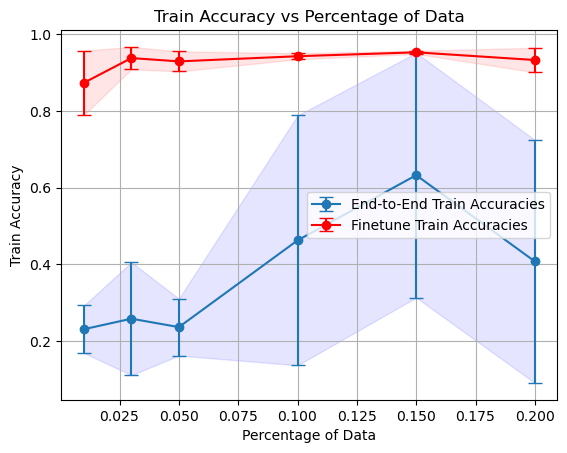

In [76]:
# End to End - Train Accuracies
means = [np.mean(results_train[perc]) for perc in percentages]
stds = [np.std(results_train[perc]) for perc in percentages]
plt.errorbar(percentages, means, yerr=stds, fmt='-o', capsize=5, label="End-to-End Train Accuracies")
plt.fill_between(percentages, np.subtract(means, stds), np.add(means, stds), color='b', alpha=0.1)

# Finetune - Train Accuracies
means = [np.mean(results_train_finetune[perc]) for perc in percentages]
stds = [np.std(results_train_finetune[perc]) for perc in percentages]
plt.errorbar(percentages, means, yerr=stds, fmt='-o', capsize=5, label="Finetune Train Accuracies", color='r')
plt.fill_between(percentages, np.subtract(means, stds), np.add(means, stds), color='r', alpha=0.1)

# Displaying the Train Accuracies plot
plt.xlabel("Percentage of Data")
plt.ylabel("Train Accuracy")
plt.title("Train Accuracy vs Percentage of Data")
plt.legend()
plt.grid(True)
plt.show()


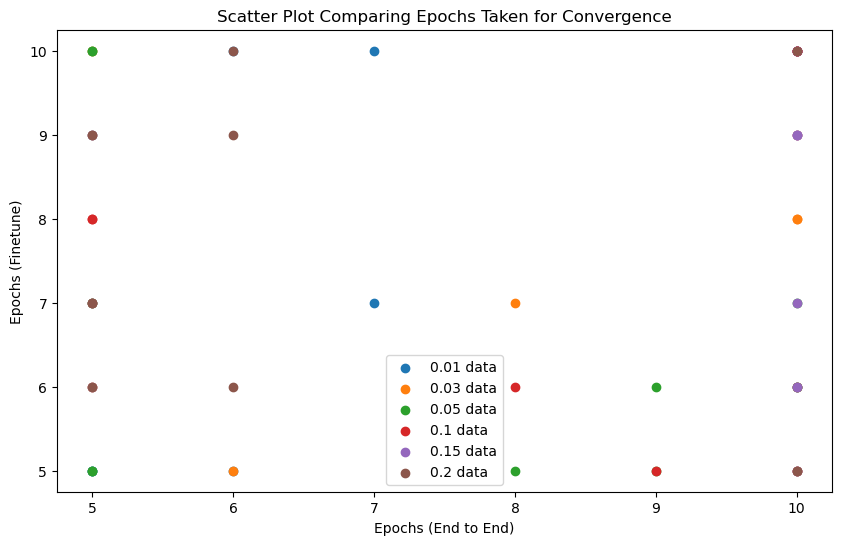

In [77]:
plt.figure(figsize=(10, 6))
for perc in percentages:
    plt.scatter(epochs_taken[perc], epochs_taken_finetune[perc], label=f'{perc} data')
plt.xlabel('Epochs (End to End)')
plt.ylabel('Epochs (Finetune)')
plt.title('Scatter Plot Comparing Epochs Taken for Convergence')
plt.legend()
plt.show()


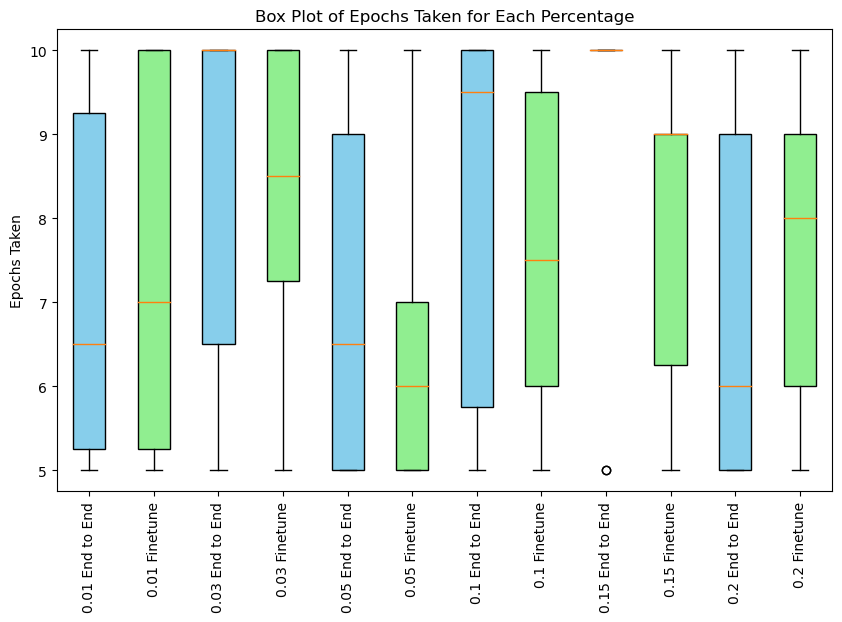

In [78]:
import matplotlib.pyplot as plt

# Given data
percentages = list(epochs_taken.keys())

all_epochs = []
labels = []

for perc in percentages:
    all_epochs.extend([epochs_taken[perc], epochs_taken_finetune[perc]])
    labels.extend([f'{perc} End to End', f'{perc} Finetune'])

# Plotting
plt.figure(figsize=(10, 6))
box = plt.boxplot(all_epochs, labels=labels, patch_artist=True)

# Coloring
colors = ['skyblue', 'lightgreen'] * len(percentages)
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.ylabel('Epochs Taken')
plt.title('Box Plot of Epochs Taken for Each Percentage')
plt.xticks(rotation=90)
plt.show()
